In [1]:
import pandas as pd
import numpy as np
from numpy import array
from pandas import read_csv
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import GRU
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from matplotlib import pyplot as plt
from itertools import chain

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/scalation/data/master/COVID/CLEANED_35.csv')
date = df['date'].tail(391-44)
deaths = df['deathIncrease'].tail(391-44)
sequence=list(deaths)

In [3]:
def split_sequence(data,steps_in,steps_out):
    X,y=list(),list()
    for i in range(len(data)):
        seq_end=i+steps_in
        end_out=seq_end+steps_out
        if end_out > len(data):
            break
        seq_x, seq_y=data[i:seq_end], data[seq_end:end_out]
        X.append(seq_x)
        y.append(seq_y)
    return array(X),array(y)

In [4]:
steps_in, steps_out = 21 , 14
X, y=split_sequence(sequence,steps_in,steps_out)

In [5]:
features=1
X=X.reshape(X.shape[0],X.shape[1],features)
print(X.shape, y.shape)

(286, 21, 1) (286, 14)


In [15]:
Tuned_model = Sequential()
Tuned_model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(steps_in, features)))
Tuned_model.add(MaxPooling1D(pool_size=2))
Tuned_model.add(Flatten())
Tuned_model.add(RepeatVector(steps_out))
Tuned_model.add(LSTM(100,activation='relu'))
Tuned_model.add(RepeatVector(steps_out))
Tuned_model.add(LSTM(100, activation='relu'))
Tuned_model.add(Dense(steps_out))
Tuned_model.compile(optimizer='adam',loss='mape')
Tuned_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 20, 64)            192       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 10, 64)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 640)               0         
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 14, 640)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               296400    
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 14, 100)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)              

m = 286, tr_size = 143, te_size = 143, kt = 143, h = 10
(143, 21, 1) (143, 14) (143, 21, 1) (143, 14)


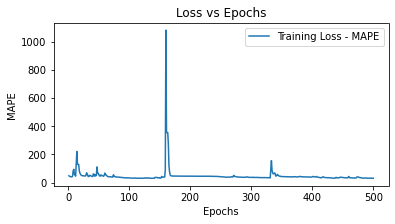

Min Training Loss = 29.319698333740234 at Epoch 138
34.3929846343282
h=1  ->  smape= 34.39
35.346503811193585
h=2  ->  smape= 35.35
42.875723055276616
h=3  ->  smape= 42.88
39.33956144352585
h=4  ->  smape= 39.34
26.46202216831438
h=5  ->  smape= 26.46
25.87648232599798
h=6  ->  smape= 25.88
35.01525512340486
h=7  ->  smape= 35.02
39.85943532177956
h=8  ->  smape= 39.86
39.84576866270302
h=9  ->  smape= 39.85
48.07700465515747
h=10 ->  smape= 48.08
44.90720296235921
h=11  ->  smape= 44.91
35.17909353019677
h=12  ->  smape= 35.18
36.837596629256495
h=13  ->  smape= 36.84
43.7208133937285
h=14  ->  smape= 43.72
rSq =['0.6202', '0.5617', '0.4166', '0.5296', '0.7559', '0.7379', '0.5370', '0.4441', '0.3910', '0.2705', '0.3446', '0.5058', '0.4731', '0.3089'] mape =['34.52', '36.68', '43.95', '42.68', '29.38', '27.38', '34.90', '36.83', '35.89', '44.80', '43.36', '31.92', '33.29', '37.63'] smape =['34.39', '35.35', '42.88', '39.34', '26.46', '25.88', '35.02', '39.86', '39.85', '48.08', '44.91

In [17]:
rSq, mape, smape, mse, rmse, sse, sst, beats, prediction, y_e = rollingValidate(Tuned_model, True, X, y, -1, 10, 0, 500, 16, True, True, True)
print("rSq ="+str(rSq)+ " mape ="+str(mape) +" smape ="+ str(smape)+" mse ="+ str(mse) +" rmse ="+ str(rmse)+" sse ="+ str(sse)+ " sst ="+ str(sst))

In [7]:
def train50(X,y):
    TR_RATIO = 0.5
    m = y.shape[0]
    tr_size = int(m * TR_RATIO)
    te_size = int(m - tr_size)
    te = int(tr_size)
   # if kt < 0: kt = te_size
    #print("m = "+str(m)+", tr_size = "+str(tr_size)+", te_size = "+str(te_size))
    
    (x_e, y_e, x_r, y_r) = chopr (X, y, te, te_size, tr_size)
    return x_e, y_e, x_r, y_r

In [8]:
def plotHistory(fit_history,ls="MAPE"):
    #Get training loss
    loss = fit_history.history['loss']
    # val_loss = fit_history.history['val_loss']

    # Create count of the number of epochs
    epoch_count = range(1, len(loss) + 1)

#     # Visualize loss history - Plotting Loss vs Number of Epochs during training
    plt.figure(num=0,figsize=(6,3))
    plt.plot(epoch_count, loss)
    # plt.plot(val_loss)
    plt.legend(['Training Loss - '+str(ls), 'Validation Loss - '+str(ls)])
    plt.xlabel('Epochs')
    plt.ylabel(ls)
    plt.title("Loss vs Epochs")
    plt.show()

#     print("_________________________________________________________________________________________")
    print("Min Training Loss = " + str(np.min(loss)) + " ",end='')
    print("at Epoch " + str(np.argmin(loss) + 1))
    # print("Min Validation Loss = " + str(np.min(val_loss)) + " ",end='')
    # print("at Epoch " + str(np.argmin(val_loss) + 1))
#     print("__________________________________________________________________________________________")

In [9]:
def eval(y,yp):
    # print(y)
    # print(yp)
    import math
    roundTo = 5
    m = y.shape[0]
    # print(m)
    e = np.array(y - yp)

    # print("m")
    # print(e)
    yt = np.array(y - y.mean())
    sse = e.dot(e)
    sst = yt.dot(yt)
    rSq = round((1 - ((sse)/(sst))),roundTo)
    mape = round(((np.absolute(e)/np.absolute(y)).sum())*100/m,roundTo)
    t = (np.absolute(e)/(np.absolute(y)+np.absolute(yp)))
    print(t.sum()*200/m)
    smape = round(((np.absolute(e)/(np.absolute(y)+np.absolute(yp))).sum())*200/m,roundTo)
    # smape  = 200 * (e.abs / (yy.abs + yp.abs)).sum / m
    mse = round((sse/m),roundTo)
    rmse = round(math.sqrt(mse),roundTo)
#     return(rSq,mape,mse,rmse,sse,sst)
    return(format(rSq,'.4f'),format(mape,'.2f'),format(smape,'.2f'),format(mse,'.2f'),format(rmse,'.2f'),format(sse,'.2f'),format(sst,'.2f'))

In [10]:
def rollingValidate(model, train, x, y, kt, h, callbk, nEpoch, nBatch, plot, p1, p2):
    TR_RATIO = 0.5
    m = y.shape[0]
    tr_size = int(m * TR_RATIO)
    te_size = int(m - tr_size)
    te = int(tr_size)
    if kt < 0: kt = te_size
    print("m = "+str(m)+", tr_size = "+str(tr_size)+", te_size = "+str(te_size)+", kt = "+str(kt)+", h = "+str(h))
    
    (x_e, y_e, x_r, y_r) = chopr (x, y, te, te_size, tr_size)
    print(x_e.shape, y_e.shape, x_r.shape, y_r.shape)
    # print(type(y_r))
    # print(y_r.index)
    
    # print(type(y_e))
    # print(y_e.index)
    #print(y_e.shape)
    #y_e = np.array(y_e)
    #print(y_e)
   # smapearr = [x for x in range(10,24)]
   # for h in range(1,15):
   #     yr =  y_r[h-1]
   #     inp = y_e[h-1].tolist()
   #     yrw = inp[:-h]
       
   #     for i in range(h):
   #         yrw.insert(i,inp[i])
   #     yrw = np.array(yrw)
   #     rSqr, maper, smaper, mser, rmser, sser, sstr = eval(y_e[h-1],yrw)
   #     smapearr[h-1] = smaper
#     x_r = x_r[1000:]
#     y_r = y_r[1000:]
#     print("Training shape"+str(x_r.shape))
#     print("Training shape"+str(y_r.shape))
#     print("Testing shape"+str(x_e.shape))
#     print("Testing shape"+str(y_e.shape))
    rt = 0
#     print("number of re-trainings required = "+str(int((te_size/kt)+1)))
    for i in range(y_e.shape[0]):
        if i%kt == 0:
            rt = rt + 1
            if i > 0:
                x_r, y_r = shift_rm((x_r,y_r),((x_e.iloc[i-kt:i], y_e.iloc[i-kt:i])))
            if train:
                if callbk==1:
                    callb = callbacks.EarlyStopping(monitor='loss', restore_best_weights=True, patience=20,verbose=1)
                else: callb = None
             
                fit_history = model.fit(x_r, y_r,validation_split=0.10,shuffle=True,epochs=nEpoch, \
                                        batch_size=nBatch,verbose=0, callbacks=callb) #callbacks=[tfa.callbacks.TQDMProgressBar(leave_epoch_progress=False,show_epoch_progress=False)]  workers=10, use_multiprocessing=True,
            if plot: plotHistory(fit_history)
#     print("\nOut-Sample Results")
#    rw = np.array([2.47,3.79,4.6,5.23,5.75,6.18,6.61,6.94,7.29,7.70]) #RW results - mape for 50% TR
#    rw = np.array([float(x) for x in smapearr]) #calculated using python
    beats = []
    
    prediction = model.predict(x_e,batch_size=100)
    rSq  = [x for x in range(14)]
    mse  = [x for x in range(14)]
    sse  = [x for x in range(14)]
    sst  = [x for x in range(14)]
    rmse = [x for x in range(14)]
    mape = [x for x in range(14)]
    smape = [x for x in range(14)]
    maxdif = 0
    maxdifh = 0

    for h in range(1,15):
        yf = prediction[:,h-1]
        rSq[h-1], mape[h-1], smape[h-1], mse[h-1], rmse[h-1], sse[h-1], sst[h-1] = eval(y_e[:,h-1],yf)
       # diff = (rw[h-1] - float(mape[h-1]))
        #if rw[h-1] >= float(mape[h-1]): beats.append(h)
        #if diff > maxdif:
        #    maxdif = diff
        #    maxdifh = h
        if p1:
            if h != 10:print("h="+str(h)+"  -> "+" smape= "+str(smape[h-1]))     #" sse = "+str(sse[h-1]) +
            else:print("h="+str(h)+" -> "+" smape= "+str(smape[h-1]))            #" sse = "+str(sse[h-1]) +
#             if h != 10: print("h="+str(h)+"  -> "+"rsq = "+str(rSq[h-1])+" mape = "+str(mape[h-1])+","+str(format(rw[h-1],'.2f'))+" mse = "+str(mse[h-1])+" rmse = "+str(rmse[h-1]) +" sst = "+str(sst[h-1])) #" sse = "+str(sse[h-1]) +
#             else: print("h="+str(h)+" -> "+"rsq = "+str(rSq[h-1])+" mape = "+str(mape[h-1])+","+str(format(rw[h-1],'.2f'))+" mse = "+str(mse[h-1])+" rmse = "+str(rmse[h-1]) +" sst = "+str(sst[h-1])) #" sse = "+str(sse[h-1]) +
#         print("h="+str(h)+" -> "+" mape = "+str(mape)+","+str(rw[h-1])+" rsq = "+str(rSq))
    #if p2: 
        #print("Beats RW at "+str(len(beats))+" values of h="+str(beats))
        #print("Max difference = "+str(maxdif)+" at horizon h="+str(maxdifh))
    return (rSq, mape, smape, mse, rmse, sse, sst, beats, prediction, y_e)

In [11]:
def chopr(x,y,te,te_size,tr_size):
    te2 = te + te_size
    tr = te - tr_size
#     print("te="+str(te))
#     print("te_size="+str(te_size))
#     print("tr_size="+str(tr_size))
    x_e = x[te:te2]
    y_e = y[te:te2]
    x_r = x[tr:te]
    y_r = y[tr:te]
    
#     print("test: x_e("+str(te)+" .. "+str(te2-1)+")")
#     print("test: y_e("+str(te)+" .. "+str(te2-1)+")")
#     print("train: x_r("+str(tr)+" .. "+str(te-1)+")")
#     print("train: y_r("+str(tr)+" .. "+str(te-1)+")")
    return(x_e, y_e, x_r, y_r)

[1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 4, 3, 2, 1, 4, 3, 2, 1, 4, 3, 2, 1]
